# Adaptive Algorithms
We have already discussed stochastic optimization problem:
```{math}
:label: eq-stoc-opt-chap4-restate
\min_{\vw}\ \ell(\vw) := \EE_{\xi\sim\mathcal{D}}[\ell(\vw,\xi)]
```
where $\mathcal{D}$ is the data distribution. Note that for neural network training, we usually collect a set of training data $\{\xi_i\}_{i=1,2,...,n}$ and optimize for the training loss
```{math}
:label: eq-stoc-opt-finite-sum-chap4-restate
\min_{\vw}\ \ell(\vw) := \frac{1}{n}\sum_{i=1}^{n}\ell(\vw, \xi_i)
```
which is also know as the finite sum setting of the stochastic optimization.

(subsec:minibatch-and-momentum)=
## Mini-batch and momentums

The basic stochastic gradient descent (SGD) scheme (the key update in {prf:ref}`alg:SGD`) is to simply sample a random sample $\xi_t$ at iteration $t$, and update
```{math}
:label: eq-SGD-chap4
\vw^{t+1}\gets \vw^{t} - \eta_t\nabla \ell(\vw^t, \xi_t).
```

As discussed in Chapter 2, stochastic methods such as SGD only has a noisy estimate of the true gradients, thus suffering from the inexactness of the noise. This motivates the mini-batch version of the SGD algorithm: at each iteration, we sample a mini-batch of the data samples $\{i_{1,t},i_{2,t},...,i_{B,t}\}$ where $B$ is the so-called batch size, and update
```{math}
:label: eq-minibatch-SGD-chap4
\vw^{t+1}\leftarrow \vw^{t} - \frac{\eta_t}{B}\sum_{j=1}^{B}\nabla \ell(\vw^t, \xi_{i_{j,t}}).
```
Intuitively, the larger the batch size $B$ is, the closer the average of stochastic gradient is to the true gradient $\nabla \ell(\vw^t)$. 

Below we have a simple example on training a simple two layer neural network for classifying MNIST hand-written digits $0$ and $1$. We just test the effect of different batch sizes and record the distance of the stochastic gradient toward the true gradient.

Batch size: 4, Avg distance to full grad: 2.307725
Batch size: 8, Avg distance to full grad: 1.388254
Batch size: 16, Avg distance to full grad: 0.961190
Batch size: 32, Avg distance to full grad: 1.106750
Batch size: 64, Avg distance to full grad: 0.771912
Batch size: 128, Avg distance to full grad: 0.791104
Batch size: 256, Avg distance to full grad: 0.989365
Batch size: 512, Avg distance to full grad: 0.835109


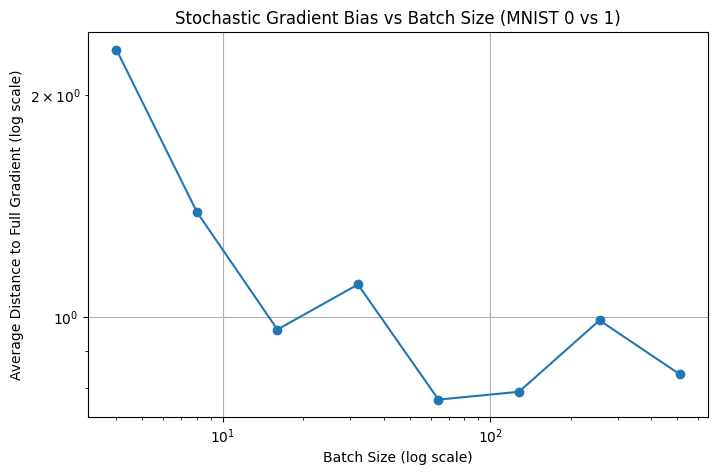

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
import numpy as np

# Binary classification: digits 0 vs 1
def get_mnist_binary():
    transform = transforms.ToTensor()
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    indices = [i for i, (_, y) in enumerate(train_dataset) if y in [0, 1]]
    binary_subset = Subset(train_dataset, indices)
    return binary_subset

class TwoLayerNN(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Get gradient for a batch
def get_gradients(model, x, y):
    criterion = nn.BCELoss()
    model.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    grads = []
    for p in model.parameters():
        if p.grad is not None:
            grads.append(p.grad.view(-1))
    return torch.cat(grads).detach()

# Compute full gradient using a large batch
def compute_full_gradient(model, dataloader):
    all_grads = []
    for x, y in dataloader:
        x = x.view(x.size(0), -1)
        y = y.float().view(-1, 1)
        g = get_gradients(model, x, y)
        all_grads.append(g)
    return torch.stack(all_grads).mean(dim=0)

# Compute average distance to true gradient
def compute_avg_distance_to_full_grad(model, dataloader, full_grad, num_batches=20):
    dists = []
    for i, (x, y) in enumerate(dataloader):
        if i >= num_batches:
            break
        x = x.view(x.size(0), -1)
        y = y.float().view(-1, 1)
        g = get_gradients(model, x, y)
        dist = torch.norm(g - full_grad).item() ** 2
        dists.append(dist)
    return np.mean(dists)

# Main
batch_sizes = [4, 8, 16, 32, 64, 128, 256, 512]
distances = []

torch.manual_seed(0)
dataset = get_mnist_binary()

# Use large batch to compute full gradient (approximate full dataset)
large_batch_loader = DataLoader(dataset, batch_size=2048, shuffle=False)
model_for_full = TwoLayerNN()
full_grad = compute_full_gradient(model_for_full, large_batch_loader)

# Loop over batch sizes
for batch_size in batch_sizes:
    model = TwoLayerNN()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    dist = compute_avg_distance_to_full_grad(model, dataloader, full_grad)
    print(f"Batch size: {batch_size}, Avg distance to full grad: {dist:.6f}")
    distances.append(dist)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(batch_sizes, distances, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Batch Size (log scale)')
plt.ylabel('Average Distance to Full Gradient (log scale)')
plt.title('Stochastic Gradient Bias vs Batch Size (MNIST 0 vs 1)')
plt.grid(True)
plt.show()

<!-- Resulting in the following image:
![alt text](sgd_vs_bs.png) -->

We can see from the image above that in general, a larger batch size reuslt in better approximation toward the true gradient. However, for each of the sample one need to conduct one back-propagation step, consequently a large batch size will incur a very large memory overhead.

As described in Section <span style="color:red">xxx</span>, numerous variance reduction techniques are proposed to mitigate the large variance of stochastic gradient descent, without extra memory overheads. The most popular technique is perhaps adding a momentum, resulting in the stochastic gradient descent with momentum (SGD-M) method:
```{math}
:label: eq-sgd-mmt-chap4
\begin{align}
\vg^t &\leftarrow (1-\beta)\vg^{t-1} + \beta\left(\frac{1}{B}\sum_{j=1}^{B}\nabla \ell(\vw^t, \xi_{i_{j,t}})\right)\\
\vw^{t+1} &\leftarrow \vw^{t} - \eta_t \vg^t
\end{align}
```
Note that here the batch size $B$ can be significantly smaller than the batch size $B$ in the mini-batch SGD {eq}`eq-minibatch-SGD-chap4`. 

The intuition behind SGD-M {eq}`eq-sgd-mmt-chap4` is that, as the iteration count $t$ increases, the gradient tracker $g^t$ becomes a more and more precise estimator of the true gradient. Imagine the situation where we take $\eta_t$ reasonably small so that the neighboring iterations are not too far from each other, then $\vg^t$ become a mini-batch estimator of the current gradient with a much larger batch size, thus more precise.

Below we have a simple experiment to show the effectiveness of momentum mechanism. 

Batch size: 4, Raw: 2.282789, EMA: 0.859225
Batch size: 8, Raw: 1.417440, EMA: 0.764601
Batch size: 16, Raw: 1.000241, EMA: 0.626654
Batch size: 32, Raw: 1.141169, EMA: 0.793779
Batch size: 64, Raw: 0.767402, EMA: 0.597092
Batch size: 128, Raw: 0.785263, EMA: 0.625763
Batch size: 256, Raw: 0.992621, EMA: 0.734354
Batch size: 512, Raw: 0.833885, EMA: 0.627168


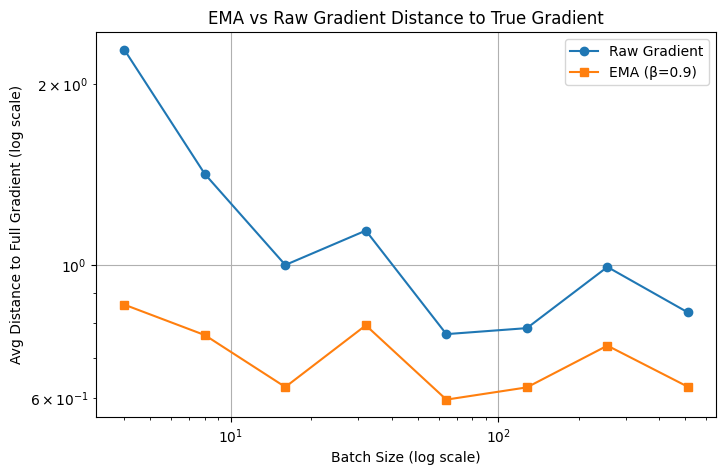

In [2]:
# Compute average distance for raw and EMA gradients
def compute_ema_vs_raw_distance(model, dataloader, full_grad, beta=0.9, num_batches=30):
    raw_dists = []
    ema_dists = []
    ema_grad = torch.zeros_like(full_grad)
    
    for i, (x, y) in enumerate(dataloader):
        if i >= num_batches:
            break
        x = x.view(x.size(0), -1)
        y = y.float().view(-1, 1)
        g = get_gradients(model, x, y)

        # EMA update
        ema_grad = beta * ema_grad + (1 - beta) * g

        # Distances
        raw_dist = torch.norm(g - full_grad).item() ** 2
        ema_dist = torch.norm(ema_grad - full_grad).item() ** 2

        raw_dists.append(raw_dist)
        ema_dists.append(ema_dist)

    return np.mean(raw_dists), np.mean(ema_dists)

# Main
batch_sizes = [4, 8, 16, 32, 64, 128, 256, 512]
raw_dists_all = []
ema_dists_all = []
beta = 0.9

torch.manual_seed(0)
dataset = get_mnist_binary()

# Full gradient (large batch)
large_loader = DataLoader(dataset, batch_size=2048, shuffle=False)
model_for_full = TwoLayerNN()
full_grad = compute_full_gradient(model_for_full, large_loader)

for batch_size in batch_sizes:
    model = TwoLayerNN()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    raw_dist, ema_dist = compute_ema_vs_raw_distance(model, dataloader, full_grad, beta=beta)
    print(f"Batch size: {batch_size}, Raw: {raw_dist:.6f}, EMA: {ema_dist:.6f}")
    raw_dists_all.append(raw_dist)
    ema_dists_all.append(ema_dist)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(batch_sizes, raw_dists_all, marker='o', label='Raw Gradient')
plt.plot(batch_sizes, ema_dists_all, marker='s', label=f'EMA (β={beta})')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Batch Size (log scale)')
plt.ylabel('Avg Distance to Full Gradient (log scale)')
plt.title('EMA vs Raw Gradient Distance to True Gradient')
plt.legend()
plt.grid(True)
plt.show()

where we can see that with a much smaller batch size, EMA enjoys a much smaller the distance to the true gradient.

## AdaGrad
So far we have introduced SGD and its momentum variants. In SGD, each parameter (the entries in the vector $\vw$) is updated with the same learning rate (step size) $\eta$. Imagine a situation where certain entries have large gradients and others have small gradients, then the entries with large gradients will always fluctuate while the entries with small gradients will barely change. Therefore, various adaptive gradient methods are proposed, aiming at mitigating the difference of entries in the parameter vecor $\vw$. Some famous adaptive methods include AdaGrad {cite}`duchi2011adagrad`, RMSProp {cite}`hinton2012rmsprop` and Adam (and AdamW) {cite}`kingma2015adam`.

AdaGrad (Adaptive Gradient Algorithm) {cite}`duchi2011adagrad` is perhaps the earliest work along this line. For each gradient entry, AdaGrad divide it by the root square sum of all historical gradients:
````{prf:algorithm} AdaGrad
:label: alg:adagrad

- **Input**: initial point $\vw^0$, stepsize sequence $\{ \eta_t \}_{t \geq 0}$, max. no. of iterations $T$.

- For $t=0,1,2,..., T-1$,
```{math}
\begin{split}
\xi_{i_{j,t}} &\sim {\cal D} \text{ (draw i.i.d. samples)} \\
\vg^t &\leftarrow \frac{1}{B}\sum_{j=1}^{B}\nabla \ell(\vw^t, \xi_{i_{j,t}}) \\
\vv^t &\leftarrow \vv^{t-1} + \vg^t \odot \vg^t \\
\vw^{t+1} &\leftarrow \vw^{t} - \eta_t \frac{\vg^t}{\sqrt{\vv^t}+\epsilon}
\end{split}
```
- **Output**: last iterate $\vw^T$, or the solution sequence $\{ \vw^t \}_{t=1}^T$.
````

where $\odot$ is entry-wise multiplication and the division of the last line is also entry-wise division. Intuitively, AdaGrad forces the entries with large gradients to update slower and the entries with small gradients to update faster.

## RMSProp

Yet another line of adaptive algorithms are more popular, including RMSProp {cite}`hinton2012rmsprop` and Adam (and AdamW) {cite}`kingma2015adam`. 

RMSProp (Root Mean Square Propagation) was first proposed in Geoffrey Hinton's lecture notes and quickly became very popular. It adopts a different idea than AdaGrad. Recall that our concern is that different entries/coordinates will have different derivatives with significant different magnitudes, one brutal remedy is to keep only the direction of them and remove the information of the magnitude. This directly leads to the sign-SGD method:
```{math}
:label: eq-sign-sgd-chap4
\begin{align}
\vg^t &\leftarrow \frac{1}{B}\sum_{j=1}^{B}\nabla \ell(\vw^t, \xi_{i_{j,t}}) \\
\vw^{t+1} &\leftarrow \vw^{t} - \eta_t \sign(\vg^t)
\end{align}
```
where $\sign$ is taking the sign of each entries of $\vg^t$, i.e. $\sign(\vg^t)$ will have entries only 1, -1 or 0. This will make the gradient contribution equally important among alll the coordinates.

Mathematically, we can write the second line of Sign-SGD {eq}`eq-sign-sgd-chap4` as an entry-wise division:
```{math}
:label: eq-sign-sgd-2-chap4
\begin{align}
\vw^{t+1} &\leftarrow \vw^{t} - \eta_t \frac{\vg^t}{\sqrt{\vg^t\odot \vg^t}}
\end{align}
```
where we simply ignore the entries which are zeros. Now that we lose all information regarding the gradient magnitudes and only utilize the gradient signs, which might be too extreme since we still want a relative larger step along the coordinates with larger gradient magnitudes. We can utilize the momentum/EMA idea to "smooth" the denominator $\sqrt{\vg^t\odot \vg^t}$ to that it varies more smoothly a iteration $t$ increases. This results in the following EMA version of signSGD, i.e. RMSProp:
````{prf:algorithm} RMSprop
:label: alg:rmsprop

- **Input**: initial point $\vw^0$, stepsize sequence $\{ \eta_t \}_{t \geq 0}$, max. no. of iterations $T$, momentum parameter $\beta$.

- For $t=0,1,2,..., T-1$,
```{math}
\begin{split}
\xi_{i_{j,t}} &\sim {\cal D} \text{ (draw i.i.d. samples)} \\
\vg^t &\leftarrow \frac{1}{B}\sum_{j=1}^{B}\nabla \ell(\vw^t, \xi_{i_{j,t}}) \\
\vv^t &\leftarrow \beta\vv^{t-1} + (1-\beta)\vg^t\odot \vg^t \\
\vw^{t+1} &\leftarrow \vw^{t} - \eta_t \frac{\vg^t}{\sqrt{\vv^t}+\epsilon}
\end{split}
```
- **Output**: last iterate $\vw^T$, or the solution sequence $\{ \vw^t \}_{t=1}^T$.
````

here $\epsilon$ is usually a small cosntant just to keep the denominator non-zero. RMSProp inherits signSGD’s robustness to scale differences but keeps enough magnitude sensitivity for efficient convergence.

## Adam
Adam (Adaptive Moment Estimation) is the default optimizer that people use when training modern large models. It combines the momentum idea we mentioned in SGD-M {eq}`eq-sgd-mmt-chap4` and RMSProp ({prf:ref}`alg:adagrad`) by keeping two moving averages:
```{math}
:label: eq-adam-proto-chap4
\begin{align}
\vg^t &\leftarrow \frac{1}{B}\sum_{j=1}^{B}\nabla \ell(\vw^t, \xi_{i_{j,t}}) \\
\vm^t &\leftarrow \beta_1\vm^{t-1} + (1-\beta_1)\vg^t \\
\vv^t &\leftarrow \beta_2\vv^{t-1} + (1-\beta_2)\vg^t\odot \vg^t \\
\vw^{t+1} &\leftarrow \vw^{t} - \eta_t \frac{\vm^t}{\sqrt{\vv^t}+\epsilon}
\end{align}
```
this is almost the Adam algorithm that people use in practice.

The real Adam further improve {eq}`eq-adam-proto-chap4` via the so-called bias-correction technique. If we assume that each $\nabla \ell(\vw^t, \xi_{i_{j,t}})$ is an unbiased estimator of a fix gradient vector $\vg$ (which would be the case if we sample each index $i_{j,t}$ independently and with sample distribution), one could calculate
```{math}
\begin{align}
\EE\vm^t &=\beta_1\EE\vm^{t-1} + (1-\beta_1)\vg \\
&= \beta_1^2\EE\vm^{t-2} + \beta_1(1-\beta_1)\vg + (1-\beta_1)\vg \\
&=...= (1-\beta_1)\sum_{\tau=1}^{t}\beta_1^{t-\tau}\vg = (1-\beta_1^t)\vg
\end{align}
```
Therefore we need a corrected estimator 
```{math}
\begin{align}
\hat{\vm}^t := \frac{\vm^t}{1-\beta_1^t},
\end{align}
```
similarly for $\vv^t$ we need
```{math}
\begin{align}
\hat{\vv}^t := \frac{\vv^t}{1-\beta_2^t}.
\end{align}
```

Now we finally reach at the full version of Adam:
````{prf:algorithm} Adam
:label: alg:adam

- **Input**: initial point $\vw^0$, stepsize sequence $\{ \eta_t \}_{t \geq 0}$, max. no. of iterations $T$, momentum parameter $(\beta_1,\beta_2)$.

- For $t=0,1,2,..., T-1$,
```{math}
\begin{split}
\xi_{i_{j,t}} &\sim {\cal D} \text{ (draw i.i.d. samples)} \\
\vg^t &\leftarrow \frac{1}{B}\sum_{j=1}^{B}\nabla \ell(\vw^t, \xi_{i_{j,t}}) \\
\vm^t &\leftarrow \beta_1\vm^{t-1} + (1-\beta_1)\vg^t \\
\vv^t &\leftarrow \beta_2\vv^{t-1} + (1-\beta_2)\vg^t\odot \vg^t \\
\hat{\vm}^t &\gets \frac{\vm^t}{1-\beta_1^t},\ \hat{\vv}^t \gets \frac{\vm^t}{1-\beta_2^t} \\
\vw^{t+1} &\leftarrow \vw^{t} - \eta_t \frac{\hat{\vm}^t}{\sqrt{\hat{\vv}^t}+\epsilon}
\end{split}
```
- **Output**: last iterate $\vw^T$, or the solution sequence $\{ \vw^t \}_{t=1}^T$.
````

Adam could be viewed as a double momentum version of sign SGD, where we replace both the numerator and denominator of {eq}`eq-sign-sgd-2-chap4` by the moving averages.

## Weight decay and AdamW
So far we have discussed Adam, the default optimizer for all LLM training. The optimizer people use in practice is in fact AdamW, a variant of Adam with weight decay. To introduce it, we need to first recall standard weight dacay. In machine learning tasks we often impose a regularization term to avoid overfitting:
```{math}
:label: eq-stoc-opt-weight-decay
\min_{\vw}\ \ell(\vw) := \EE_{\xi\sim\mathcal{D}}[\ell(\vw,\xi)] + \frac{\lambda}{2} \|\vw\|^2
```
and when taking the gradient, the stochastic gradient becomes $g^t=\nabla \ell(\vw^t,\xi_t) + \lambda\vw^t$. One can then conduct the full Adam update with this new stochastic gradient estimator.

AdamW {cite}`loshchilov2018decoupled` propose a different approach. Note that when you do the standard weight decay with $g^t=\nabla \ell(\vw^t,\xi_t) + \lambda\vw^t$, later in your Adam update, your $\hat{\vm}^t$ and $\hat{\vv}^t$ will both contain the weight decay term $\lambda\vw^t$. This is not ideal since $\hat{\vm}^t$ and $\hat{\vv}^t$ should be moving average estimates of gradient information. Therefore AdamW simply impose weight decay at the final update step (marked red):

````{prf:algorithm} AdamW
:label: alg:adamw

- **Input**: initial point $\vw^0$, stepsize sequence $\{ \eta_t \}_{t \geq 0}$, max. no. of iterations $T$, momentum parameter $(\beta_1,\beta_2)$, weight decay parameter $\lambda$.

- For $t=0,1,2,..., T-1$,
```{math}
\begin{split}
\xi_{i_{j,t}} &\sim {\cal D} \text{ (draw i.i.d. samples)} \\
\vg^t &\leftarrow \frac{1}{B}\sum_{j=1}^{B}\nabla \ell(\vw^t, \xi_{i_{j,t}}) \\
\vm^t &\leftarrow \beta_1\vm^{t-1} + (1-\beta_1)\vg^t \\
\vv^t &\leftarrow \beta_2\vv^{t-1} + (1-\beta_2)\vg^t\odot \vg^t \\
\hat{\vm}^t &\gets \frac{\vm^t}{1-\beta_1^t},\ \hat{\vv}^t \gets \frac{\vm^t}{1-\beta_2^t} \\
\vw^{t+1} &\leftarrow \vw^{t} - \eta_t \frac{\hat{\vm}^t}{\sqrt{\hat{\vv}^t}+\epsilon} \textcolor{red}{- \eta_t\lambda \vw^{t}}
\end{split}
```
- **Output**: last iterate $\vw^T$, or the solution sequence $\{ \vw^t \}_{t=1}^T$.
````

This way the weight decay is completely decoupled from the EMA estimators $\hat{\vm}^t$ and $\hat{\vv}^t$. AdamW ({prf:ref}`alg:adamw`) is the final complete version of the default optimizer that we are talking about.

## Discussion of the convergence of RMSProp and Adam
Despite the great success of RMSProp and Adam, their theoretical behavior is still unclear. In particular, the two momentum hyperparameters ($\beta_1$ and $\beta_2$) play important roles in the convergence. Intuitively, the larger $\beta_1$ and $\beta_2$ are, the smoother the corresponding $\vm^t$ and $\vv^t$ are (since they are closer to $\vm^{t-1}$ and $\vv^{t-1}$). In practice, people usually take $\beta_1=0.9$ and $\beta_2=0.999$, indicating the importance of smooth trajectories of $\vm^t$ and $\vv^t$. In theory however, it is shown that Adam could diverge with the default hyperparameters $\beta_1=0.9$ and $\beta_2=0.999$.

Specifically, {cite}`reddi2018onconvergenceofadam` shows the following result:


```{admonition} Theorem
:class: note
For any constant $\beta_1,\beta_2\in[0, 1)$, such that $\beta_1\leq\sqrt{\beta_2}$, there is a stochastic convex optimization problem for which Adam does not converge to the optimal solution.

(see Theorem 3 in {cite}`reddi2018onconvergenceofadam`)
```

Note that the condition $\beta_1\leq\sqrt{\beta_2}$ covers the default setting $\beta_1=0.9$ and $\beta_2=0.999$, therefore Adam is not converging for every stochastic optimization problem.

Since then, multiple convergence analysis are provided to cover the convergence of Adam under different hyperparameter settings. Related works include {cite}`defossez2022asimpleconvergenceproof,zhang2022adamcanconvergewithout,chen2018onconvergenceofadamtypealgorithms`. See {cite}`yushun2022doesadamconverge`  for a detailed discussion on the convergence of Adam.

## Possible homeworks:

1. implement sgd and sgd-momentum by hand, compare it with torch's implementation. Maybe easier: add momentum based on sgd implemented by torch.
2. write code (could use gpt and torch implementation) to test the memory cost by sgd and sgd momentum with different batchsizes, and figure out the maximum batchsize required to training a 1b model
3. imagine each iteration has similar gradients (such as least-squares), what are the effective learning rates of AdaGrad, RMSProp and Adam?
4. for MNIST, implement AdaGrad, RMSProp and Adam and compare their performance. Do a hyperparameter search for optimal learning rates.